# Part1 Pytorch CNN level 1 (40 points):

<p>
Make a notebook called cnnA3.ipynb.
Adapt the code from class below to use ReLU functions for the CIFAR 2-class
problem classifying cats versus dogs.
</p>


```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

return out
```


In [21]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils


torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

In [22]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it,
# downloads it if necessary, and adds additional transforms that we
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100.0%


Extracting ./cifar-10-python.tar.gz to ./


In [23]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [24]:
label_map = {3: 0, 5: 1}
class_names = ['cat', 'dog']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [3, 5]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [3, 5]]

In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


<p>

Define 30 different seeds and train this network for 100 epochs with a batch size of
64, ADAM optimizer (learning rate = 1e-4), tracking training and validation accuracy
in EACH epoch.

</p>

In [30]:
import datetime
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    accuracy = correct / total
    return accuracy  # This will be a float, not a dictionary

# Your training loop should now handle the float value correctly
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(1, n_epochs + 1):
        model.train()  # Set the model to training mode
        loss_train = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(loss_train / len(train_loader))
        train_accuracies.append(correct / total)

        # Validate after every epoch
        val_accuracy = validate(model, val_loader)  # val_accuracy is a float
        val_accuracies.append(val_accuracy)  # Append the float directly

    return train_losses, train_accuracies, val_accuracies

In [31]:
import time

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

# Lists to store accuracies and losses for all seeds
all_train_losses = []
all_train_accuracies = []
all_val_accuracies = []

model = Net().to(device)

# ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# classification loss
loss_fn = nn.CrossEntropyLoss()

# Number of seeds
num_seeds = 30


start_time = time.time()
for seed in range(num_seeds):
    print("seed: ", seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, train_accuracies, val_accuracies = training_loop(
        n_epochs=100,
        optimizer=optimizer,
        model=model,
        loss_fn=loss_fn,
        train_loader=train_loader,
        val_loader=val_loader
    )
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

end_time = time.time()
print(f"30 Seeds took {end_time - start_time} seconds to run.")


seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15
seed:  16
seed:  17
seed:  18
seed:  19
seed:  20
seed:  21
seed:  22
seed:  23
seed:  24
seed:  25
seed:  26
seed:  27
seed:  28
seed:  29
30 Seeds took 2169.218980073929 seconds to run.


<p>
Make a nice plot of the training and validation accuracy as a function of epoch
across all 30 seeds (error bars or shading!).
</p>

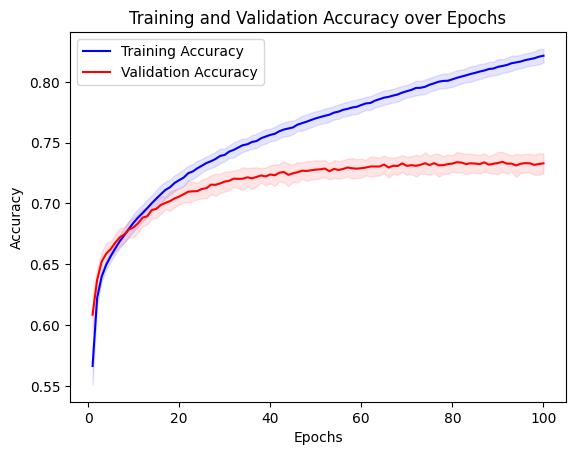

In [34]:
# Calculate the mean accuracy per epoch across all seeds

# print( all_train_accuracies, all_val_accuracies)
train_accuracies_mean = np.mean(all_train_accuracies, axis=0)
val_accuracies_mean = np.mean(all_val_accuracies, axis=0)
# print(train_accuracies_mean, val_accuracies_mean)
# Calculate the standard deviation per epoch across all seeds
train_accuracies_std = np.std(all_train_accuracies, axis=0)
val_accuracies_std = np.std(all_val_accuracies, axis=0)

# Epochs should be a list or array of the same length as the number of epochs
epochs = np.arange(1, 101)

# Now plot using 'epochs' and the calculated means and standard deviations
plt.fill_between(epochs, train_accuracies_mean - train_accuracies_std,
                 train_accuracies_mean + train_accuracies_std, color='blue', alpha=0.1)
plt.plot(epochs, train_accuracies_mean, color='blue', label='Training Accuracy')

plt.fill_between(epochs, val_accuracies_mean - val_accuracies_std,
                 val_accuracies_mean + val_accuracies_std, color='red', alpha=0.1)
plt.plot(epochs, val_accuracies_mean, color='red', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Discussion

<p>
    <i>1. Did the network train well?</i>
        <br/>
    <b>
    We think that our model has not been trained well. The training data accuracy is approximately 83% and did not converge, whereas the validation data accuracy is around 73% after 100 epochs. Which shows a significant difference. Based on these results, we can say that our model has been overfitted to the training set.
    </b>
</p>

<br/>

<p>
    <i>2. Do you think the variability across seeds is large or small? Why? </i>
        <br/>
    <b>
    The shaded area around the training and validation accuracy lines represents the variability of different seeds. The variability looks reasonable, which indicates that the results are fairly consistent. We think that this implies that the model's performance is stable across different seeds.</b>
</p>

<br/>
  
<p>
    <i>3. Load 100 random images from OTHER classes (so, NEITHER cats nor dogs) and put them into the network - how are the images classified? Do these results make “sense”?</i>
        <br/>
    <b>
    By the results in the experiment, our network classified only airplanes and automobiles correctly at all. The reason for this is that our model is only able to classify cats or dogs and can only predict the label of the image, which is 0 for cat and 1 for dog. When classifying the images from other classes, our model tries to see if the image is a cat or a dog. So, only in the case of images with the label 0 and 1 will be classified at all, and in this case that would be airplanes and automobiles. We have seen several seeds and also found that airplanes, having a small accuracy, looks more like a dog than a cat to the model. Likewise, automobiles, showing relatively high accuracy seems to look more like a dog than a cat to the model as well. So in a way we would say that it does make sense if you knew why the model only picks airplanes or automobiles, but if one were not to know, the results would be fumbling.
    </b>
</p>

<br/>

<p>
    <i>4. Taking into account the results from Question 3 - would you use this network to classify birds and airplanes in the “real” world? </i>
        <br/>
    <b>
    Given that the network was trained only on 'cats' and 'dogs', it would not be advisable to use it for classifying 'birds' and 'airplanes' in the real world. Our model lacks  the necessary knowledge to accurately distinguish these classes.
    To be able to classify birds and airplanes in the real world, we would have to train the network on birds and planes. Also, the CIFAR 10 dataset is too low quality to be able to successfully classify birds from planes since they kind of look similar. And to avoid over-fitting, training on more diverse classes look reasonable as well.
    </b>
</p>

In [53]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from collections import defaultdict, Counter

# Classes to exclude
exclude_classes = ['cat', 'dog']

# Get the indices of the classes to exclude
exclude_indices = [i for i, (image, label) in enumerate(cifar10) if cifar10.classes[label] in exclude_classes]

# Create a list of indices for all other classes
other_indices = [i for i in range(len(cifar10)) if i not in exclude_indices]

# Randomly sample 100 indices from the other classes
np.random.seed(3)  # For reproducibility
sample_indices = np.random.choice(other_indices, 100, replace=False)

# Create a subset of the CIFAR-10 dataset containing only the other classes
other_dataset = Subset(cifar10, sample_indices)

# Create a DataLoader for the subset
other_loader = DataLoader(other_dataset, batch_size=1, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Function to get predictions from outputs
def get_predictions(outputs):
    return torch.argmax(outputs, dim=1)

sampled_class_names = [cifar10.classes[label] for _, label in other_dataset]
print("Sampled class distribution:", Counter(sampled_class_names))

# Initialize counters for correct predictions and total instances per class
correct_predictions_per_class = defaultdict(int)
total_instances_per_class = defaultdict(int)

# Collect predictions and their corresponding true labels
for images, labels in other_loader:
    images = images.to(device)  
    outputs = model(images)
    predicted_classes = get_predictions(outputs).cpu().numpy()

    for label, prediction in zip(labels.numpy(), predicted_classes):
        class_name = cifar10.classes[label]
        if class_name not in exclude_classes:
            total_instances_per_class[class_name] += 1
            if label == prediction:
                correct_predictions_per_class[class_name] += 1

# Calculate and store accuracy for each class
accuracy_per_class = {}
for class_name in cifar10.classes:
    if class_name in exclude_classes:
        continue
    if total_instances_per_class[class_name] > 0:
        accuracy = correct_predictions_per_class[class_name] / total_instances_per_class[class_name]
        accuracy_per_class[class_name] = accuracy

# Print the accuracy per class
for class_name, accuracy in accuracy_per_class.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2f}")

# Print the overall accuracy dictionary
print(accuracy_per_class)


# Print the overall accuracy dictionary
print(accuracy_per_class)

Sampled class distribution: Counter({'frog': 18, 'horse': 16, 'ship': 15, 'bird': 15, 'airplane': 13, 'automobile': 9, 'deer': 9, 'truck': 5})
Accuracy for class airplane: 0.15
Accuracy for class automobile: 0.78
Accuracy for class bird: 0.00
Accuracy for class deer: 0.00
Accuracy for class frog: 0.00
Accuracy for class horse: 0.00
Accuracy for class ship: 0.00
Accuracy for class truck: 0.00
{'airplane': 0.15384615384615385, 'automobile': 0.7777777777777778, 'bird': 0.0, 'deer': 0.0, 'frog': 0.0, 'horse': 0.0, 'ship': 0.0, 'truck': 0.0}
{'airplane': 0.15384615384615385, 'automobile': 0.7777777777777778, 'bird': 0.0, 'deer': 0.0, 'frog': 0.0, 'horse': 0.0, 'ship': 0.0, 'truck': 0.0}


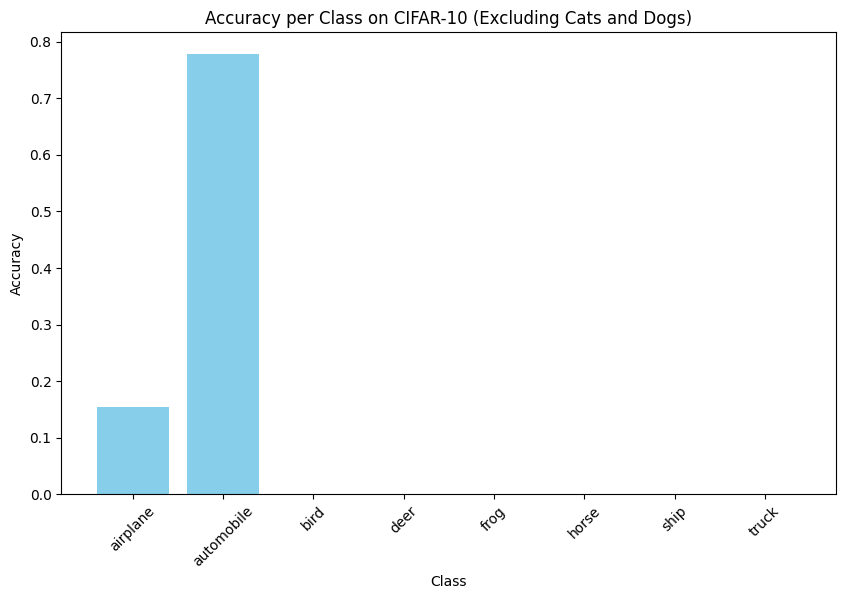

In [54]:
import matplotlib.pyplot as plt

# Prepare data for plotting
classes = list(accuracy_per_class.keys())
accuracies = list(accuracy_per_class.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, accuracies, color='skyblue')

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class on CIFAR-10 (Excluding Cats and Dogs)')

# Rotate class labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


# Part2 Pytorch CNN comparison (40 points):

<p>
Add all code to cnnA3.ipynb.
Following Part 1, now train each of the following modules with the SAME optimizer
and dataloader parameters for the same 30 seeds, adapting each to use the ReLU
functions - use the default parameters as defined in class:
</p>

```python
    class NetWidth(nn.Module), 
    class NetDropout(nn.Module), 
    class NetBatchNormalization(nn.Module), 
    class NetResDeep(nn.Module), 
    class NetWidthProject(nn.Module), 
    class NetWidthEmbed(nn.Module)
```




In [18]:
class NetWidth(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2 , 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, self.n_ch1 * 8 * 8 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetDropout(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # add the dropout layer
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # add the dropout layer
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        # add call to dropout
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # add call to dropout
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetBatchNormalization(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv1's output channels
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_ch1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv2's output channels
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_ch1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        # add call to batch normalization layer
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        # add call to batch normalization layer
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    

class ResBlock(nn.Module):
    def __init__(self, n_ch):
        super(ResBlock, self).__init__()
        # here we now explicitly get rid of the biases as we use BN
        self.conv = nn.Conv2d(n_ch, n_ch, kernel_size=3, padding=1, bias=False)
        # batch normalization
        self.batch_norm = nn.BatchNorm2d(num_features=n_ch)
        # BN is initialized to have 0.5 "variance" and 0 mean
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        # this is a special initialization of the convolution weights
        # that was found to help with optimization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        
        
    def forward(self, x):
        # simple forward function that includes skip connection
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    
    
class NetResDeep(nn.Module):
    # the constructor now has a parameter n_blocks that determines how many
    # ResBlocks will be used
    def __init__(self, n_ch1=32, n_blocks=10):
        super().__init__()
        self.n_ch1 = n_ch1
        # initial convolution for embedding
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # add the ResBlocks to the network
        # nn.Sequential makes sure that we can add them together nicely
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_ch=n_ch1)]))
        # note that the "net" effect of the blocks does not reduce the dimensionality
        # of the features - hence, we again have 8x8 "pixels" resolution here
        self.fc1 = nn.Linear(8*8*n_ch1, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_ch1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetWidthProject(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3,padding=1)
        # keeps the number of filters
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 // 2, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = torch.relu(self.conv3(out))
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetWidthEmbed(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3,padding=1)
        # reduces the number of filters by 2
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 // 4, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 4, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)  # Size: (batch_size, n_ch1, 16, 16)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)  # Size: (batch_size, n_ch1 // 2, 8, 8)
        out = torch.relu(self.conv3(out))  # Size should still be (batch_size, n_ch1 // 2, 8, 8)
        # Flatten the output for the fully connected layer
        # Make sure the number of features matches the output of the last conv layer
        out = out.view(-1, 8 * 8 * self.n_ch1 // 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out



In [19]:
import time

net_classes = [NetWidth, NetDropout, NetBatchNormalization, NetResDeep, NetWidthProject, NetWidthEmbed]

# Training parameters
num_seeds = 30
n_epochs = 100
batch_size = 64
learning_rate = 1e-4

# Set up your DataLoaders
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)

mean_train_losses_by_class = {}
mean_train_accuracies_by_class = {}
mean_val_accuracies_by_class = {}
std_train_accuracies_by_class = {}
std_val_accuracies_by_class = {}

total_start_time = time.time()

# Loop over each network class
for NetClass in net_classes:
    all_train_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    
    start_time = time.time()
    
    # Loop over each seed
    for seed in range(num_seeds):
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Initialize the network and move it to the device
        model = NetClass().to(device)

        # Define the optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()

        # Train the model
        train_losses, train_accuracies, val_accuracies = training_loop(
            n_epochs=n_epochs,
            optimizer=optimizer,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # Store or log the metrics
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

    end_time = time.time()

    # Calculate and store mean metrics
    mean_train_losses = np.mean([np.mean(va) for va in all_train_losses])
    mean_train_accuracies = np.mean([np.mean(va) for va in all_train_accuracies])
    mean_val_accuracies = np.mean([np.mean(va) for va in all_val_accuracies])

    mean_train_losses_by_class[NetClass.__name__] = mean_train_losses
    mean_train_accuracies_by_class[NetClass.__name__] = mean_train_accuracies
    mean_val_accuracies_by_class[NetClass.__name__] = mean_val_accuracies

    # Calculate and store standard deviations
    flat_train_accuracies = [acc for sublist in all_train_accuracies for acc in sublist]
    flat_val_accuracies = [acc for sublist in all_val_accuracies for acc in sublist]
    
    std_train_accuracies_by_class[NetClass.__name__] = np.std(flat_train_accuracies)
    std_val_accuracies_by_class[NetClass.__name__] = np.std(flat_val_accuracies)

    print(f'Mean validation accuracy for {NetClass.__name__}: {mean_val_accuracies:.4f}')
    print(f"Training for {NetClass.__name__} took {end_time - start_time} seconds.")

total_end_time = time.time()
print(f"Total time for all NetClasses took {total_end_time - total_start_time} seconds to run.")

Mean validation accuracy for NetWidth: 0.7327
Training for NetWidth took 2197.798421859741 seconds.
Mean validation accuracy for NetDropout: 0.7150
Training for NetDropout took 2262.6173646450043 seconds.
Mean validation accuracy for NetBatchNormalization: 0.7428
Training for NetBatchNormalization took 2485.2005443573 seconds.
Mean validation accuracy for NetResDeep: 0.5901
Training for NetResDeep took 6528.486196756363 seconds.
Mean validation accuracy for NetWidthProject: 0.7335
Training for NetWidthProject took 2499.80441737175 seconds.
Mean validation accuracy for NetWidthEmbed: 0.7289
Training for NetWidthEmbed took 2432.9035155773163 seconds.
Total time for all NetClasses took 18406.826280355453 seconds to run.


<p>

Plot the result for each of the 30 network seeds as a grouped bar graph that has on
the x-axis the different networks with each network having training accuracy and
validation accuracy next to each other. Remember to also include the original results
from Net from Part 1. Please use proper error bars like so (plot is NOT complete):

</p>

<img src="./화면 캡처 2023-11-09 101748.png">


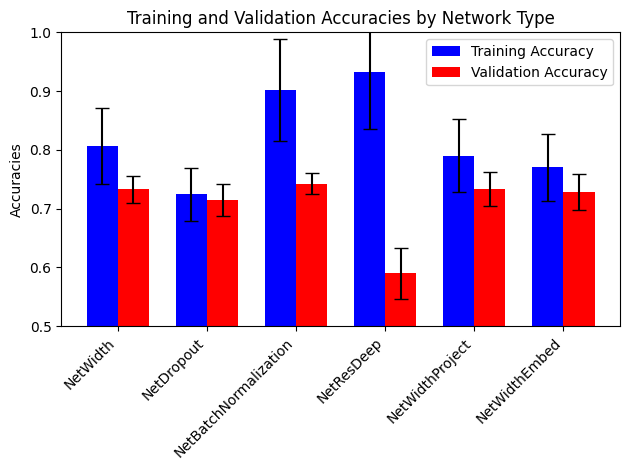

In [20]:

net_names = list(mean_train_accuracies_by_class.keys())
mean_train_accuracies = list(mean_train_accuracies_by_class.values())
mean_val_accuracies = list(mean_val_accuracies_by_class.values())
std_train_accuracies = list(std_train_accuracies_by_class.values()) # Assuming this exists
std_val_accuracies = list(std_val_accuracies_by_class.values()) # Assuming this exists


# Number of networks
n_networks = len(net_classes)

# X locations for the groups
ind = np.arange(n_networks)
# Width of the bars
width = 0.35

# Plotting
fig, ax = plt.subplots()

# Training accuracies
train_rects = ax.bar(ind - width/2, mean_train_accuracies, width, yerr=std_train_accuracies,
                     label='Training Accuracy', color='blue', capsize=5)

# Validation accuracies
val_rects = ax.bar(ind + width/2, mean_val_accuracies, width, yerr=std_val_accuracies,
                   label='Validation Accuracy', color='red', capsize=5)

net_names = [cls.__name__ for cls in net_classes]

# Axes and labels
ax.set_ylabel('Accuracies')
ax.set_title('Training and Validation Accuracies by Network Type')
ax.set_xticks(ind)
ax.set_xticklabels(net_names, rotation=45, ha="right")
ax.legend()


# Set the lower limit of y-axis to cut off the bottom of the chart
ax.set_ylim([0.5, 1])  # Replace lower_limit and upper_limit with desired values


# Make the labels readable
fig.tight_layout()

# Show the plot
plt.show()

# Discussion


<i>1. Are the resulting architectures (significantly) different in terms of their accuracies (for training and validation)?</i>
  <br/>
<b>We wouldn't say that the validation accuracies are significantly different but the training accuracies are somewhat different. Training accuracy seems to vary from 70% to 100% while the validation accuracy lies in the 3-quarters range. To be specific for each model, the NetBatchNormalization model and especially the NetResDeep model showed high training accuracy compared to its validation accuracy which means it thinks that it is good at the task but not as much as it expects, and so has been overfitted. but for NetWidth, Net Dropout, NetWidthProject, NetwidthEmbed models show relatively low difference between the training and validation accuracy which means it hasn't been overfitted as much. But since the validation accuracy was highest with the NetBatchNormalization model, we chose this model for best performance.</b>

  <br/>

<i>2. Taking into account the number of parameters in each model, is there a relationship between training accuracy and number of parameters? (For this, you can also use another, adequate plot to support your answer)</i>
  <br/>
<b>As shown in the scatter plot below, we could say that there is a relationship between the training accuracy and the number of parameters. It doesn't show a lovely increasing linear form, but most models except for 1, show that the increase in number of parameters lead to more accurate models. However, we think that this does not necessarily translate to better validation accuracy due to the risk of overfitting.</b>

In [55]:
# Saving calculated values
torch.save(mean_train_losses, 'mean_train_losses.pt')

torch.save(mean_train_accuracies, 'mean_train_accuracy.pt')
torch.save(mean_val_accuracies, 'mean_val_accuracy.pt')

torch.save(std_train_accuracies, 'std_train_accuracy.pt')
torch.save(std_val_accuracies, 'std_val_accuracy.pt')

# loaded_train_accuracies = torch.load('mean_train_accuracy.pt')
# loaded_val_accuracies = torch.load('mean_val_accuracy.pt')

# print(
#    [np.array_equal(mean_train_accuracy[n], loaded_train_accuracies[n]) for n in mean_train_accuracy.keys()],
#    [np.array_equal(mean_val_accuracy[n], loaded_val_accuracies[n]) for n in mean_val_accuracy.keys()])

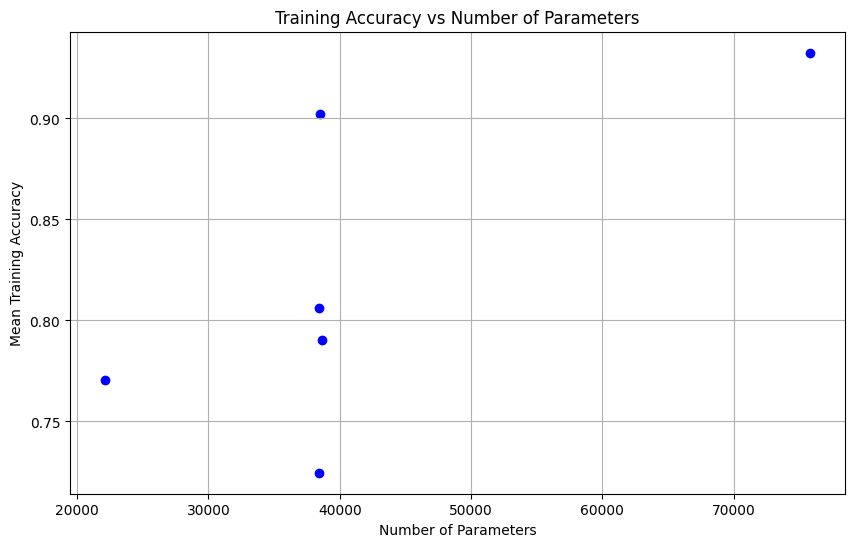

In [33]:
# Function to calculate the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Lists to store the number of parameters and accuracies
num_parameters = []
train_accuracies = []

# Loop through each class and calculate
for NetClass in net_classes:
    # Instantiate the model and count its parameters
    model = NetClass().to(device)
    num_params = count_parameters(model)
    num_parameters.append(num_params)
    
    # Get the corresponding training accuracy
    train_accuracy = mean_train_accuracies_by_class[NetClass.__name__]
    train_accuracies.append(train_accuracy)

# Now plot
plt.figure(figsize=(10, 6))
plt.scatter(num_parameters, train_accuracies, color='blue')
plt.title('Training Accuracy vs Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Mean Training Accuracy')
plt.grid(True)
plt.show()

# Part3 Pytorch Multiclass (60 points):

<p>

Add your code to cnnA3.ipynb.
Adapt the network architecture that worked best in Part 2 to now work with the full
10 classes from CIFAR. Keep the batch size and everything else the same and
re-train the network 20 times for 200 epochs, again tracing training and validation
accuracy for each epoch. Note that this will take more time due to the increased size
of the training set!


</p>

<img src="./화면 캡처 2023-11-09 101928.png">


In [34]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Set CUDA_LAUNCH_BLOCKING=1 environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Define the network architecture
class NetBatchNormalization(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv1's output channels
        self.conv1_batchnorm = nn.BatchNorm2d(n_ch1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv2's output channels
        self.conv2_batchnorm = nn.BatchNorm2d(n_ch1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_batchnorm(out)
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.conv2(out)
        out = self.conv2_batchnorm(out)
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Load the full CIFAR-10 datasets
train_dataset = cifar10
val_dataset = cifar10_val


from torch.utils.data import DataLoader

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Training parameters
n_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_accuracies = []
val_accuracies = []
all_train_preds = []
all_train_targets = []
all_val_preds = []
all_val_targets = []

# Train the network
for seed in range(20):  # Train the network 20 times
    
    print(f'Seed {seed}')
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = NetBatchNormalization().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    seed_train_accuracies = []
    seed_val_accuracies = []
    seed_train_preds = []
    seed_train_targets = []
    seed_val_preds = []
    seed_val_targets = []

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        correct = 0
        total = 0
        train_preds = []
        train_targets = []
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        seed_train_accuracies.append(correct / total)
        seed_train_preds.append(train_preds)
        seed_train_targets.append(train_targets)

        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        seed_val_accuracies.append(correct / total)
        seed_val_preds.append(val_preds)
        seed_val_targets.append(val_targets)

    train_accuracies.append(seed_train_accuracies)
    val_accuracies.append(seed_val_accuracies)
    all_train_preds.append(seed_train_preds)
    all_train_targets.append(seed_train_targets)
    all_val_preds.append(seed_val_preds)
    all_val_targets.append(seed_val_targets)


end_time = time.time()
print(f"20 times took {end_time - start_time} seconds to run.")

Seed 0
Seed 1
Seed 2
Seed 3
Seed 4
Seed 5
Seed 6
Seed 7
Seed 8
Seed 9
Seed 10
Seed 11
Seed 12
Seed 13
Seed 14
Seed 15
Seed 16
Seed 17
Seed 18
Seed 19
20 times took 122601.73250389099 seconds to run.


Plot the accuracy results like in Parts 1,2 as a function of epoch across seeds.
In addition, plot and nicely label a so-called confusion matrix for all 10 classes both
for your final training and validation performance (so, that’s two matrices).
In order to do this, you need to check which class is predicted for a given “true” label
and then simply plot the result as a matrix. Make sure to use percentages!!
Note also, that you need to do this averaged across your 20 seeds!!
Something similar to this should come out, where the true class is on the bottom
axis!

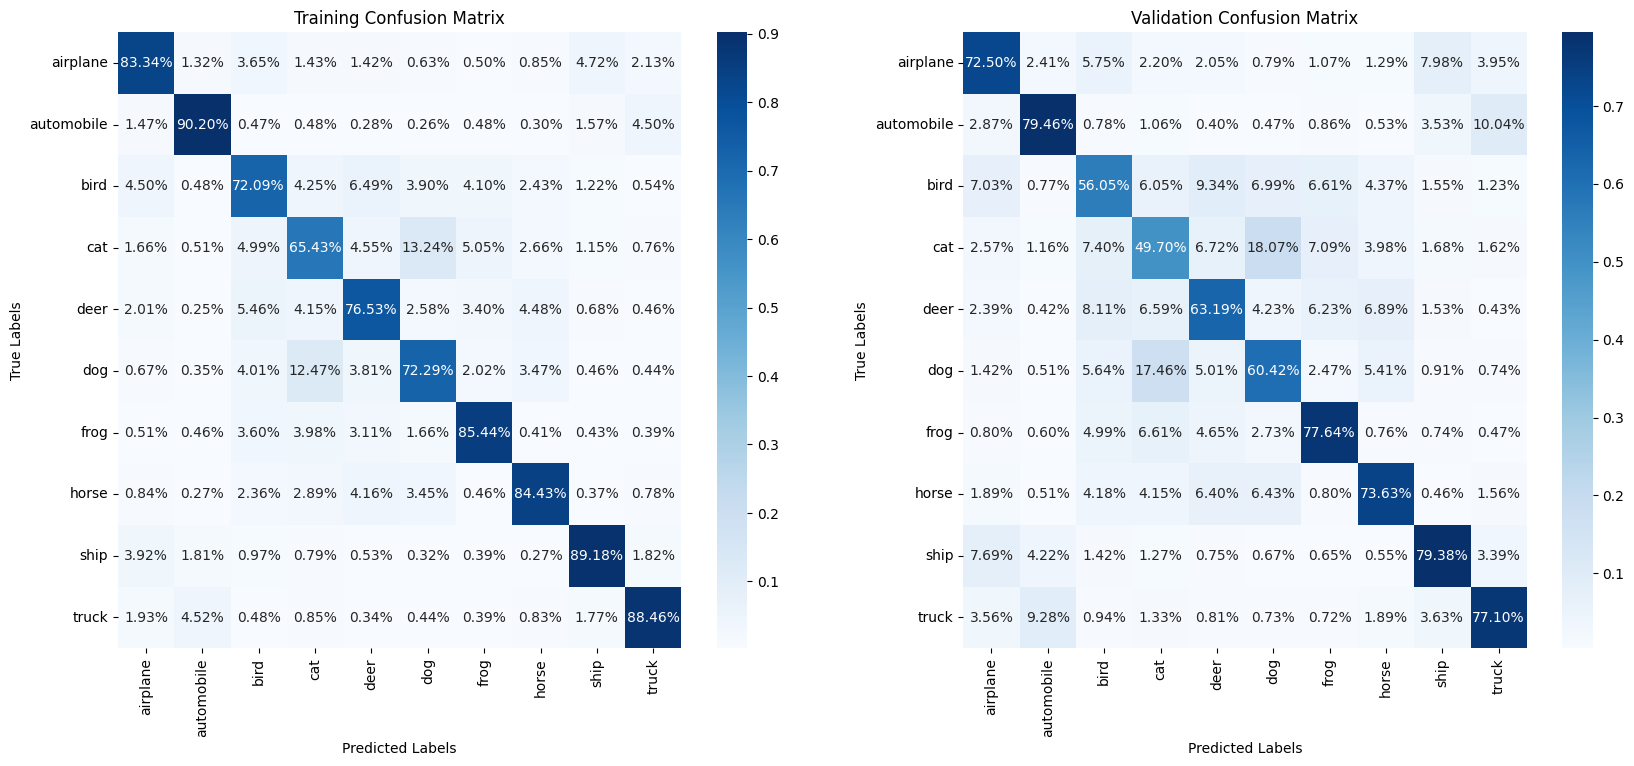

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Flatten the lists of predictions and targets
flat_train_preds = np.concatenate([np.array(preds).flatten() for preds in all_train_preds])
flat_train_targets = np.concatenate([np.array(targets).flatten() for targets in all_train_targets])
flat_val_preds = np.concatenate([np.array(preds).flatten() for preds in all_val_preds])
flat_val_targets = np.concatenate([np.array(targets).flatten() for targets in all_val_targets])

# Now, flat_train_preds and flat_train_targets should be one-dimensional arrays
# Let's try computing the confusion matrix again
try:
    cm_train = confusion_matrix(flat_train_targets, flat_train_preds, normalize='true')
    cm_val = confusion_matrix(flat_val_targets, flat_val_preds, normalize='true')
except ValueError as e:
    print(f"An error occurred: {e}")
    print(f"Shapes - flat_train_targets: {flat_train_targets.shape}, flat_train_preds: {flat_train_preds.shape}")
    # This will help to debug the issue further

# Calculate the confusion matrices for the flat lists
cm_train = confusion_matrix(flat_train_targets, flat_train_preds, normalize='true')
cm_val = confusion_matrix(flat_val_targets, flat_val_preds, normalize='true')

# Plotting the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm_train, annot=True, fmt=".2%", cmap='Blues', ax=ax[0], xticklabels=class_names, yticklabels=class_names)
ax[0].set_title('Training Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(cm_val, annot=True, fmt=".2%", cmap='Blues', ax=ax[1], xticklabels=class_names, yticklabels=class_names)
ax[1].set_title('Validation Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()


# Discussion

<i> 1. Did the networks overfit? a. If not, how could you make them overfit? </i>
  <br/>
<b> By looking at the confusion matrices, it doesn't seem like there is significant overfitting, as the validation accuracies are generally high and comparable to the training accuracies. However, it could be said that some classes could be called as over fit. For example, most of the classes show about 10% drop in accuracy from training to validation but some classes show more than 15% drops (e.g., bird, cat). </b>

  <br/>

<i> 2. Which classes can your architecture do well?</i>
  <br/>
<b>  Our model seems to perform well on classes with distinct features that are less likely to be confused with others, such as 'automobile', 'ship', 'truck', and 'airplane' as seen by the high diagonal values in both training and validation.</b>

  <br/>

<i> 3. Which classes have the smallest / largest differences in training versus validation accuracy?</i>
  <br/>
<b>**Smallest Differences:** Classes such as 'ship' and 'truck' show relatively small differences between training and validation accuracy, suggesting that our model is good at classifying them.
**Largest Differences:** The 'cat' and 'bird' class shows the largest drop from training to validation, which could indicate overfitting or that the model struggles with this class in classification.</b>

  <br/>

<i> 4. Do the confusion patterns in the matrices “make sense”?</i>
  <br/>
<b> We think that the patterns make some sense based on the traits of the CIFAR 10 dataset.
The 'cat' class is often confused with 'dog', which is understandable given the visual similarities between the classes in appearance.
The 'truck' class is sometimes confused with 'automobile', which also makes sense due to shared characteristics between these vehicle types.
Classes with distinct shapes and features, like 'ship' are less confused with others. 
But interestingly, the 'airplane' class was more confused as a 'ship' than a 'bird' so we think that we could say that the model thinks the details like metalic components larger than overall appearance</b>